In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# TensorFlow/Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification, pipeline, AutoTokenizer

# Statsmodels & Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# XGBoost and LightGBM
import xgboost as XGBRegressor
import lightgbm as lgb

# SHAP
import shap

# NLTK and TextBlob
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
import nltk

# Yahoo Finance
import yfinance as yf



# Project


# Dataset Cleaning Tweets


In [3]:
# Define columns you want to keep
columns_to_keep = ['date', 'text']

# Create an empty CSV to save the cleaned version
output_file = 'bitcoin_tweets_date_text.csv'
first_chunk = True

for chunk in pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets.csv', chunksize=100000, engine='python'):  
    chunk = chunk[columns_to_keep]
    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

In [4]:
df_raw = pd.read_csv("/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/bitcoin_tweets_date_text.csv")

In [5]:
df_raw.head()

,date,text
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...


In [6]:
# clean df 
df_raw = df_raw.sort_values(by = 'date')
dd = df_raw.sample(frac= 0.05, replace=False, random_state=1)
dd.reset_index(inplace=True)
for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
tweets_clean_file = '/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv'
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

  6%|▋         | 29592/469309 [10:37<2:37:46, 46.45it/s]  


KeyboardInterrupt: 

In [7]:
df_clean = pd.read_csv('/Users/farazmustafa/Documents/Git/Crypto Project/Capstone/Capstone Project/Bitcoin_tweets_clean.csv')

In [8]:
df_clean.head()

,index,date,text
0,3885516,2022-07-15 13:47:46,Aeron (ARNX) went up 11.6 percent in the last ...
1,984434,2021-08-16 05:15:11,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,207647,2021-06-21 21:42:06,I have made 23X gain from doge. Now how many X...
3,2529662,2022-03-16 16:05:00,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,552292,2021-07-18 14:28:49,This is definitely going to be HUGE! as the t...


In [9]:


df = df_clean.copy()
df = df[['text']] 
df.columns = ['tweets']
df.head()

,tweets
0,Aeron (ARNX) went up 11.6 percent in the last ...
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...
2,I have made 23X gain from doge. Now how many X...
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...
4,This is definitely going to be HUGE! as the t...


In [10]:


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/farazmustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [12]:
# Clean missing tweets
df['tweets'] = df['tweets'].fillna("")

# Clean tweets
df['cleaned_tweets'] = df['tweets'].apply(cleaning)

# Set date properly
df['date'] = df_clean['date']   # WARNING: make sure df_clean has no weird data
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Drop bad rows where date_clean is NaT
df = df.dropna(subset=['date_clean'])

# Drop old 'date' column
df.drop(columns='date', inplace=True)

# Show result
df.head()


,tweets,cleaned_tweets,date_clean
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18


### EDA-Tweets

In [13]:
# Create daily tweet aggregation with cleaned data
daily_tweets = df.groupby('date_clean').size().reset_index(name='tweet_count')

# Print daily tweet statistics
print("Daily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Daily tweet statistics:
count     222.000000
mean     1056.211712
std       758.638716
min         6.000000
25%       322.750000
50%       946.000000
75%      1595.500000
max      3492.000000
Name: tweet_count, dtype: float64


In [14]:
print(df['date_clean'].min())
print(df['date_clean'].max())


2021-02-05
2023-01-09


# Data Bitcoin Prices

In [15]:
# Fetch historical Bitcoin prices
def get_btc_prices(start_date='2021-02-05', end_date='2023-01-09'):
    btc = yf.Ticker("BTC-USD")
    df = btc.history(start=start_date, end=end_date)
    return df[['Close', 'Volume']].rename(columns={'Close': 'price'})

# Sentiment Analysis

In [16]:
tokenizer = AutoTokenizer.from_pretrained('ElKulako/cryptobert')
model = AutoModelForSequenceClassification.from_pretrained('ElKulako/cryptobert')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def batch_sentiment(texts, batch_size=32):
    sentiments = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        results = sentiment_pipeline(batch)
        sentiments.extend(results)
    return sentiments

Device set to use mps:0


In [17]:
# Apply sentiment analysis
sentiments = batch_sentiment(df['cleaned_tweets'].tolist())
df['sentiment'] = [s['label'] for s in sentiments]
df['sentiment_score'] = [s['score'] for s in sentiments]

In [27]:
df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159


## Data Integration

In [18]:
print(df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score'],
      dtype='object')


In [19]:
# Updated function to get multiple crypto prices
def get_crypto_prices(tickers=['BTC-USD'], start_date='2020-01-01', end_date='2023-12-31'):
    data = {}
    for ticker in tickers:
        crypto = yf.Ticker(ticker)
        hist = crypto.history(start=start_date, end=end_date)
        if not hist.empty:
            sym = ticker.split('-')[0]
            # price series
            data[sym] = hist['Close']
            # volume series
            data[f'{sym}_volume'] = hist['Volume']
    return pd.DataFrame(data)

# Get prices for all cryptos
top_cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'SOL-USD', 'XRP-USD']
price_df = get_crypto_prices(top_cryptos)
price_df.index = price_df.index.tz_localize(None).strftime('%Y-%m-%d')
merged_df = pd.merge(df,
                     price_df,
                     left_on='date_clean',
                     right_index=True,
                     how='inner')

# Create target variable (BTC's next day price movement)
merged_df['price_change_btc'] = merged_df['BTC'].pct_change().shift(-1)

# Clean up any missing values
merged_df = merged_df.dropna(subset=['price_change_btc'])

In [20]:
print(merged_df.columns)

Index(['tweets', 'cleaned_tweets', 'date_clean', 'sentiment',
       'sentiment_score', 'BTC', 'BTC_volume', 'ETH', 'ETH_volume', 'BNB',
       'BNB_volume', 'ADA', 'ADA_volume', 'SOL', 'SOL_volume', 'XRP',
       'XRP_volume', 'price_change_btc'],
      dtype='object')


In [43]:
merged_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341


### Trading Strategy

In [22]:
def trading_strategy(df, threshold=0.5):
    """Generate trading signals based on sentiment thresholds"""
    df['signal'] = 'HOLD'
    df.loc[df['sentiment_score'] > threshold, 'signal'] = 'BUY'  
    df.loc[df['sentiment_score'] < -threshold, 'signal'] = 'SELL'  
    return df
# Apply strategy
strategy_df = trading_strategy(merged_df.copy())

In [42]:
strategy_df.head()

,tweets,cleaned_tweets,date_clean,sentiment,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume,price_change_btc,signal
0,Aeron (ARNX) went up 11.6 percent in the last ...,Aeron ARNX went percent last minute rgEAV yjP ...,2022-07-15,Neutral,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333,1.207898,BUY
1,Bitcoin looking bullish👍\n\nA Golden Cross on ...,Bitcoin looking bullish A Golden Cross daily t...,2021-08-16,Neutral,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221,-0.311443,BUY
2,I have made 23X gain from doge. Now how many X...,I made X gain doge Now many XXX f cked Bitcoin...,2021-06-21,Bullish,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475,0.298871,BUY
3,NEED a JOB?\nSign up now /o7lVlsl75X\nFREE. NO...,NEED JOB Sign lVlsl X FREE NO MIDDLEMEN Java P...,2022-03-16,Neutral,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473,-0.227181,BUY
4,This is definitely going to be HUGE! as the t...,This definitely going HUGE team inspiration in...,2021-07-18,Bullish,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722,-0.067341,BUY


## Model Training

In [2]:
ml_df = merged_df.copy()

NameError: name 'merged_df' is not defined

In [98]:
ml_df = ml_df.drop(columns=['tweets', 'cleaned_tweets', 'price_change_btc', 'sentiment'])

ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
0,2022-07-15,0.512964,20836.328125,25905575359,1233.129150,17411448225,238.573990,1151260376,0.442456,739541229,37.415928,1.266227e+09,0.334535,1512184333
1,2021-08-16,0.631751,46004.484375,32776876610,3156.509521,23080039949,417.470856,2620571467,2.079417,4479074279,62.432465,3.799339e+09,1.190993,8364848221
2,2021-06-21,0.684342,31676.693359,52809038594,1888.447510,33745173825,270.984436,2911962314,1.177480,3987752749,26.657400,7.603445e+08,0.610388,4048720475
3,2022-03-16,0.738551,41143.929688,39616916192,2772.055664,17915109769,385.528229,1788844135,0.838374,1233395707,87.903625,2.370877e+09,0.793538,2480411473
4,2021-07-18,0.543159,31796.810547,18787986667,1895.552124,13791868728,302.480499,1254819647,1.183698,1354296229,26.751909,2.303364e+08,0.587922,1567538722


In [99]:
crypto_columns = crypto_columns = [
    'BTC', 'BTC_volume',
    'ETH', 'ETH_volume',
    'BNB', 'BNB_volume',
    'ADA', 'ADA_volume',
    'SOL', 'SOL_volume',
    'XRP', 'XRP_volume'
]
scaler = MinMaxScaler()
ml_df[crypto_columns] = scaler.fit_transform(ml_df[crypto_columns])

### Exploratary Data Analysis

In [100]:
ml_df.info()
ml_df.describe()
ml_df.isnull().sum()
ml_df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 234478 entries, 0 to 234653
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date_clean       234478 non-null  object 
 1   sentiment_score  234478 non-null  float64
 2   BTC              234478 non-null  float64
 3   BTC_volume       234478 non-null  float64
 4   ETH              234478 non-null  float64
 5   ETH_volume       234478 non-null  float64
 6   BNB              234478 non-null  float64
 7   BNB_volume       234478 non-null  float64
 8   ADA              234478 non-null  float64
 9   ADA_volume       234478 non-null  float64
 10  SOL              234478 non-null  float64
 11  SOL_volume       234478 non-null  float64
 12  XRP              234478 non-null  float64
 13  XRP_volume       234478 non-null  float64
dtypes: float64(13), object(1)
memory usage: 26.8+ MB


np.int64(23564)

In [102]:
ml_df['date_clean'] = pd.to_datetime(ml_df['date_clean'])
ml_df = ml_df.sort_values('date_clean')

In [103]:
ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
190775,2021-02-05,0.539968,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
166331,2021-02-05,0.638531,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101285,2021-02-05,0.639123,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101288,2021-02-05,0.691379,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
45286,2021-02-05,0.804063,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359


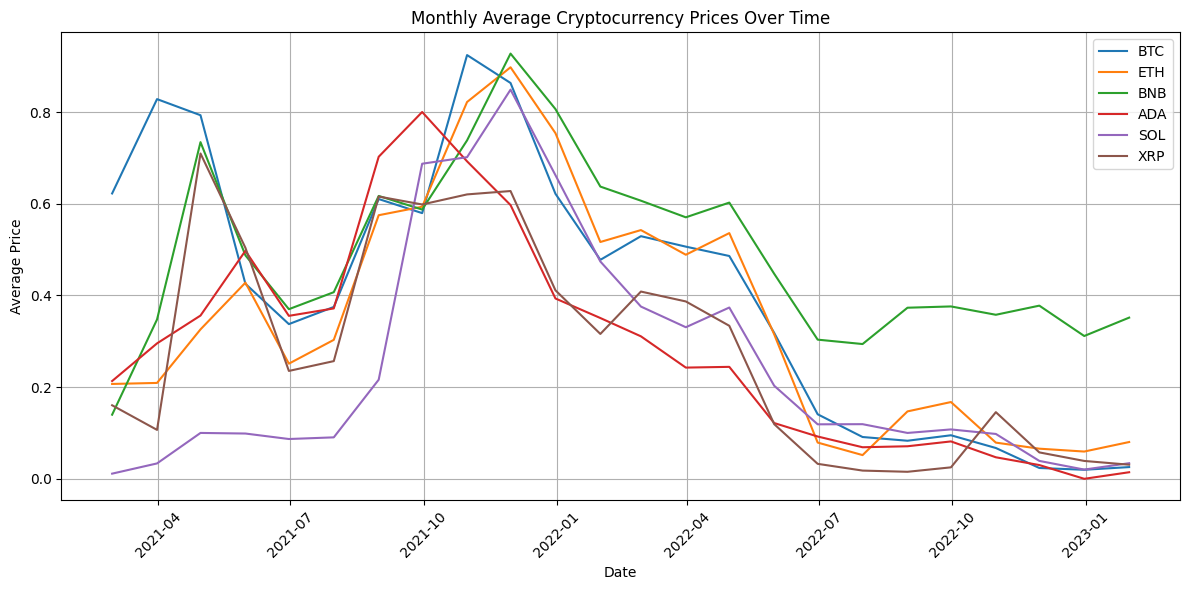

In [106]:
# Aggregate by month (mean)
# Set date as index for resampling
ml_df_indexed = ml_df.set_index('date_clean')

# Aggregate by month (mean)
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
monthly_avg = ml_df_indexed[crypto_columns].resample('M').mean()

# Plot
plt.figure(figsize=(12, 6))
for coin in crypto_columns:
    plt.plot(monthly_avg.index, monthly_avg[coin], label=coin)

plt.legend()
plt.title('Monthly Average Cryptocurrency Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

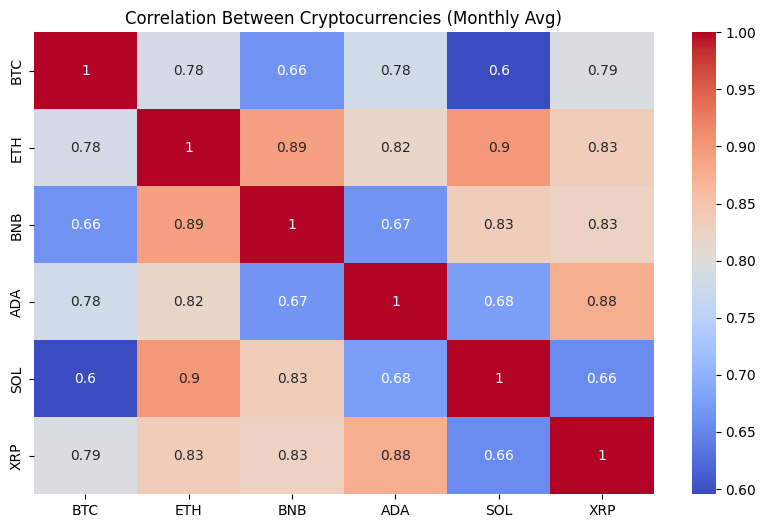

In [108]:
# Set date as index for resampling
ml_df_indexed = ml_df.set_index('date_clean')

# Recalculate monthly data (mean)
crypto_columns = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']
monthly_df = ml_df_indexed[crypto_columns].resample('M').mean()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Cryptocurrencies (Monthly Avg)')
plt.show()

Number of data points: 24


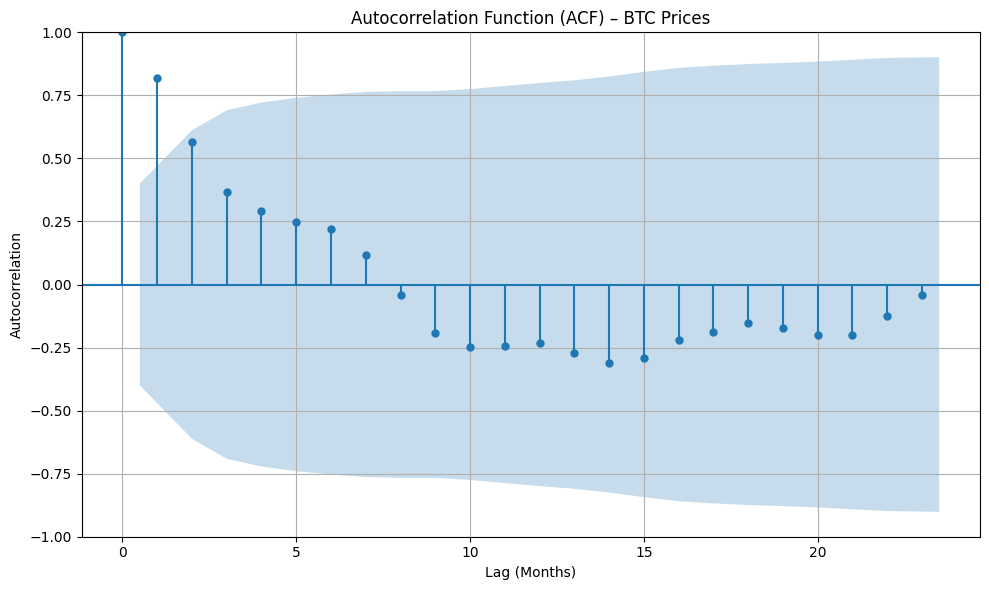

In [110]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

ml_df_indexed = ml_df.set_index('date_clean')

# Resample to monthly average
btc_monthly = ml_df_indexed['BTC'].resample('M').mean()

# Check the number of available data points
num_data_points = len(btc_monthly.dropna())
print(f"Number of data points: {num_data_points}")

# Plot ACF with a safe number of lags
plt.figure(figsize=(10, 6))
plot_acf(btc_monthly.dropna(), lags=min(48, num_data_points - 1), ax=plt.gca())
plt.title('Autocorrelation Function (ACF) – BTC Prices')
plt.xlabel('Lag (Months)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()



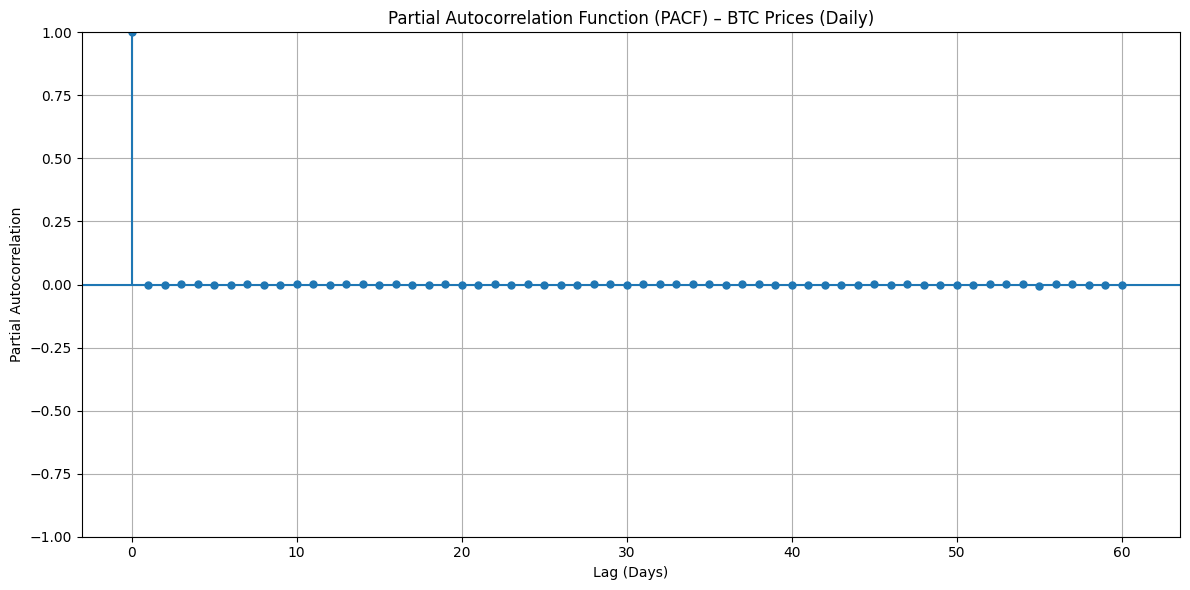

In [53]:
# Resample to monthly average
btc_daily = ml_df['BTC'].dropna()

# Safety check: max allowed lags for PACF is < 50% of data length
max_allowed_lag = (len(btc_daily) // 2) - 1
safe_lag = min(60, max_allowed_lag) 

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(btc_daily, lags=safe_lag, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) – BTC Prices (Daily)')
plt.xlabel('Lag (Days)')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Feature Importance

            Feature    Importance
5               XRP  6.497507e-01
1               ETH  3.052952e-01
4               SOL  1.867854e-02
3               ADA  1.594038e-02
8        ADA_volume  3.223178e-03
10       XRP_volume  2.968496e-03
2               BNB  2.261812e-03
6        ETH_volume  7.774896e-04
9        SOL_volume  5.765747e-04
7        BNB_volume  5.276185e-04
0   sentiment_score  7.097205e-14


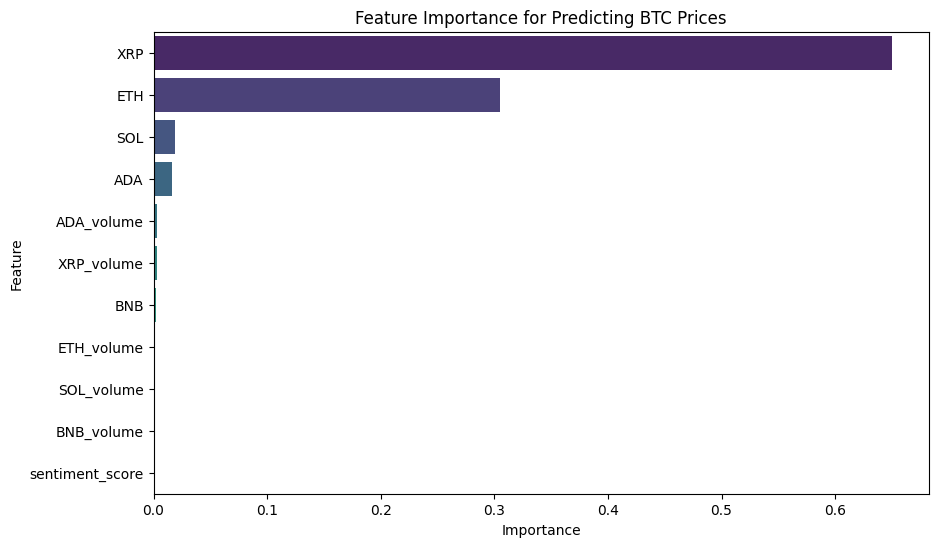

In [111]:
# Define the features (independent variables)
features = ml_df[['sentiment_score', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP', 'ETH_volume', 'BNB_volume', 'ADA_volume', 'SOL_volume', 'XRP_volume']]

# Define the target (dependent variable), e.g., BTC prices
target = ml_df['BTC']

# Train a RandomForest model using the features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features, target)

# Extract feature importances and create a DataFrame to visualize
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})

# Sort the features by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances
print(importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Predicting BTC Prices')
plt.show()

In [112]:
ml_df.head()

,date_clean,sentiment_score,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
190775,2021-02-05,0.539968,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
166331,2021-02-05,0.638531,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101285,2021-02-05,0.639123,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
101288,2021-02-05,0.691379,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359
45286,2021-02-05,0.804063,0.44531,0.457264,0.194023,0.710394,0.0,0.065256,0.104813,0.429471,0.002258,0.002103,0.113387,0.272359


In [113]:
output_path = "ml_df-1.csv"
ml_df.to_csv(output_path, index=False)
print(f"Dataset successfully saved to {output_path}")

Dataset successfully saved to ml_df-1.csv


## Crypto Model

In [3]:
# Define the crypto tickers and their labels
crypto_tickers = {
    'BTC-USD': 'BTC',
    'ETH-USD': 'ETH',
    'BNB-USD': 'BNB',
    'ADA-USD': 'ADA',
    'SOL-USD': 'SOL',
    'XRP-USD': 'XRP'
}

# Define the time range
start_date = '2020-04-10'
end_date = '2025-04-30'

In [4]:
# Download data
crypto_data = {}
for ticker in crypto_tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close', 'Volume']].rename(columns={'Close': crypto_tickers[ticker], 'Volume': f"{crypto_tickers[ticker]}_volume"})
    crypto_data[crypto_tickers[ticker]] = data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Combine all crypto data on date
crypto_ml_df = pd.concat(crypto_data.values(), axis=1, join='inner')
crypto_ml_df.reset_index(inplace=True)
crypto_ml_df.head()

Price,Date,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
0,2020-04-10,6865.493164,43622840992,158.412445,17980944616,13.737724,394331907,0.033215,95977717,0.951054,87364276,0.187464,2105282079
1,2020-04-11,6859.083008,31222085946,158.216019,13555089447,13.804288,364313702,0.033354,75648111,0.776819,43862444,0.188063,1847482831
2,2020-04-12,6971.091797,35759567632,161.142426,15123721386,14.375111,414752932,0.033806,73751090,0.882507,38736897,0.190135,2087857417
3,2020-04-13,6845.037598,38619308647,156.279556,16465282133,15.034427,459561236,0.033107,84000834,0.777832,18211285,0.187732,2253497429
4,2020-04-14,6842.427734,34110434052,157.596390,14723156630,15.525076,515331620,0.032974,74633336,0.661925,16747614,0.185335,1889687587


### Crypto EDA

In [6]:
# Create a copy to avoid modifying original
crypto_scaled_df = crypto_ml_df.copy()


In [7]:
# Select only numeric columns to scale (excluding 'Date')
numeric_cols = crypto_scaled_df.select_dtypes(include='number').columns

In [8]:
# Initialize and apply scaler
scaler = MinMaxScaler()
crypto_scaled_df[numeric_cols] = scaler.fit_transform(crypto_scaled_df[numeric_cols])

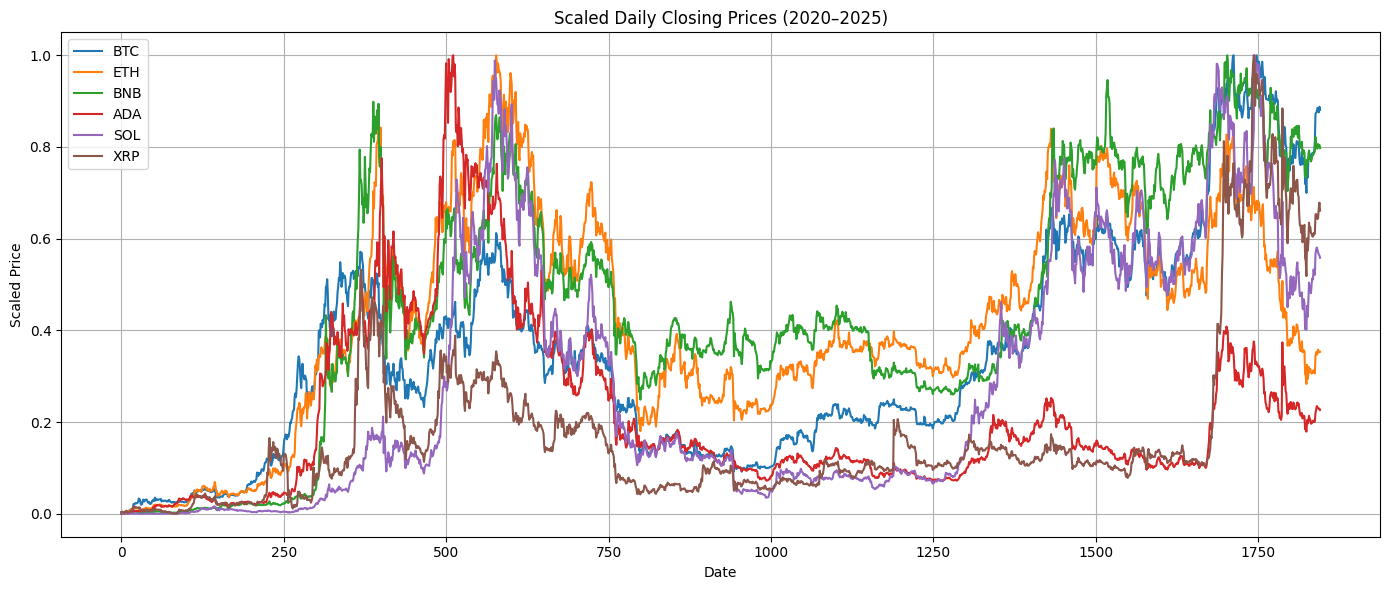

In [9]:
plt.figure(figsize=(14, 6))
for coin in ['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']:
    plt.plot(crypto_scaled_df.index, crypto_scaled_df[coin], label=coin)

plt.title('Scaled Daily Closing Prices (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

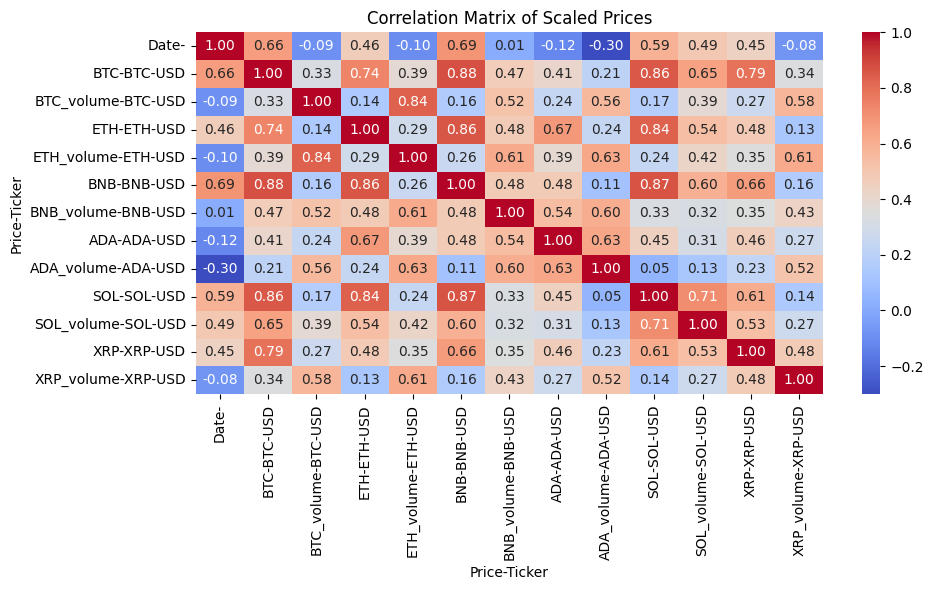

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(crypto_scaled_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Prices')
plt.tight_layout()
plt.show()


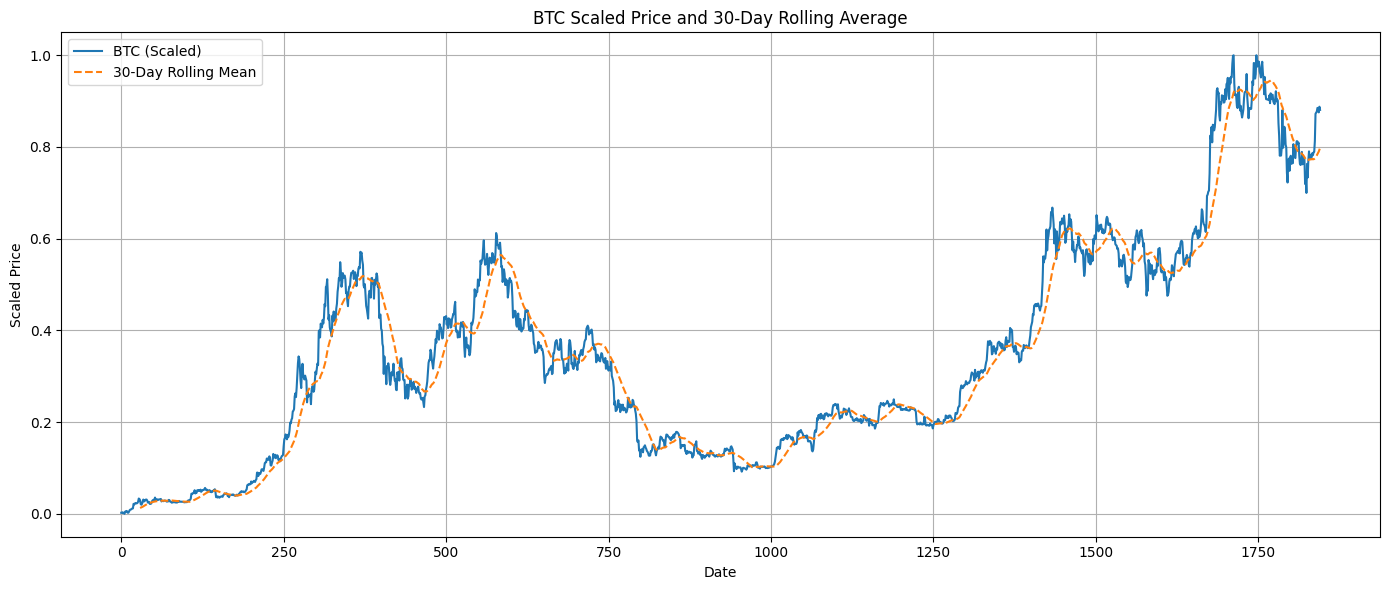

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'], label='BTC (Scaled)')
plt.plot(crypto_scaled_df.index, crypto_scaled_df['BTC'].rolling(window=30).mean(), 
         label='30-Day Rolling Mean', linestyle='--')

plt.title('BTC Scaled Price and 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


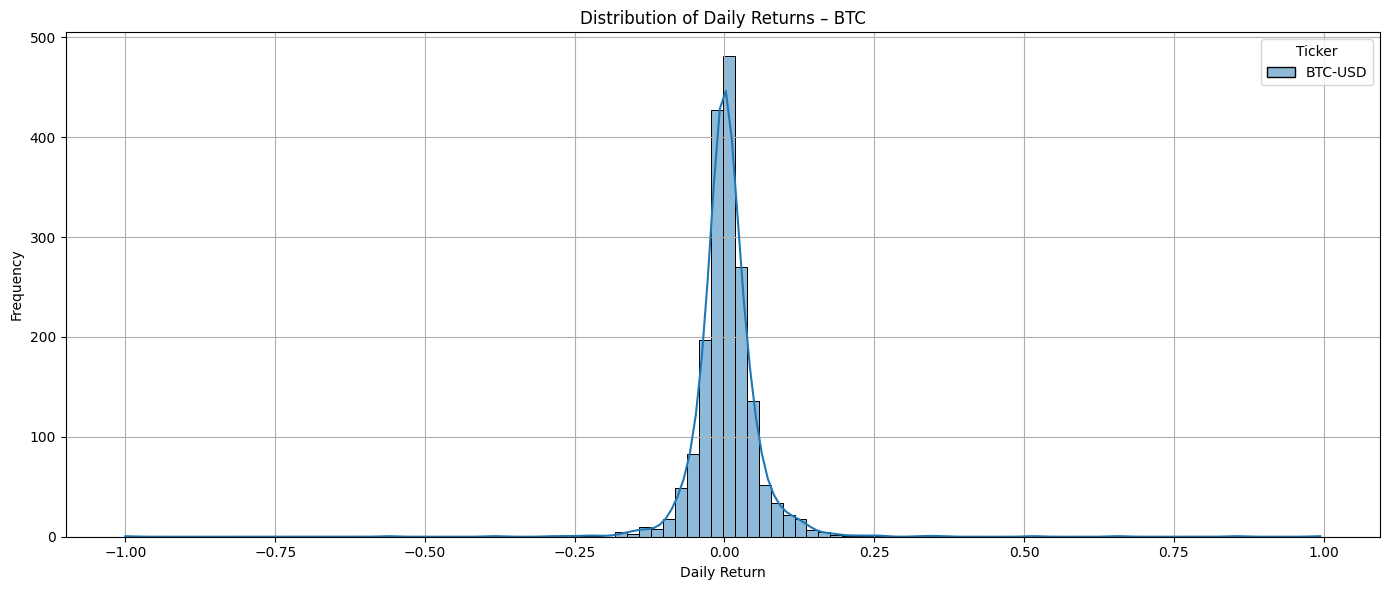

In [12]:
# Reset index so 'date' becomes a column temporarily
crypto_temp = crypto_scaled_df.reset_index()

# Compute daily returns (excluding 'date' column)
crypto_returns = crypto_temp[['BTC', 'ETH', 'BNB', 'ADA', 'SOL', 'XRP']].pct_change().dropna()

# Plot distribution for BTC
plt.figure(figsize=(14, 6))
sns.histplot(crypto_returns['BTC'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Daily Returns – BTC')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

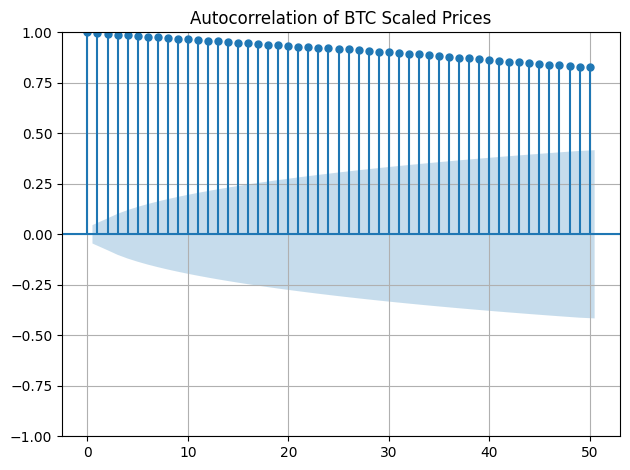

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(crypto_scaled_df['BTC'].dropna(), lags=50)
plt.title('Autocorrelation of BTC Scaled Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


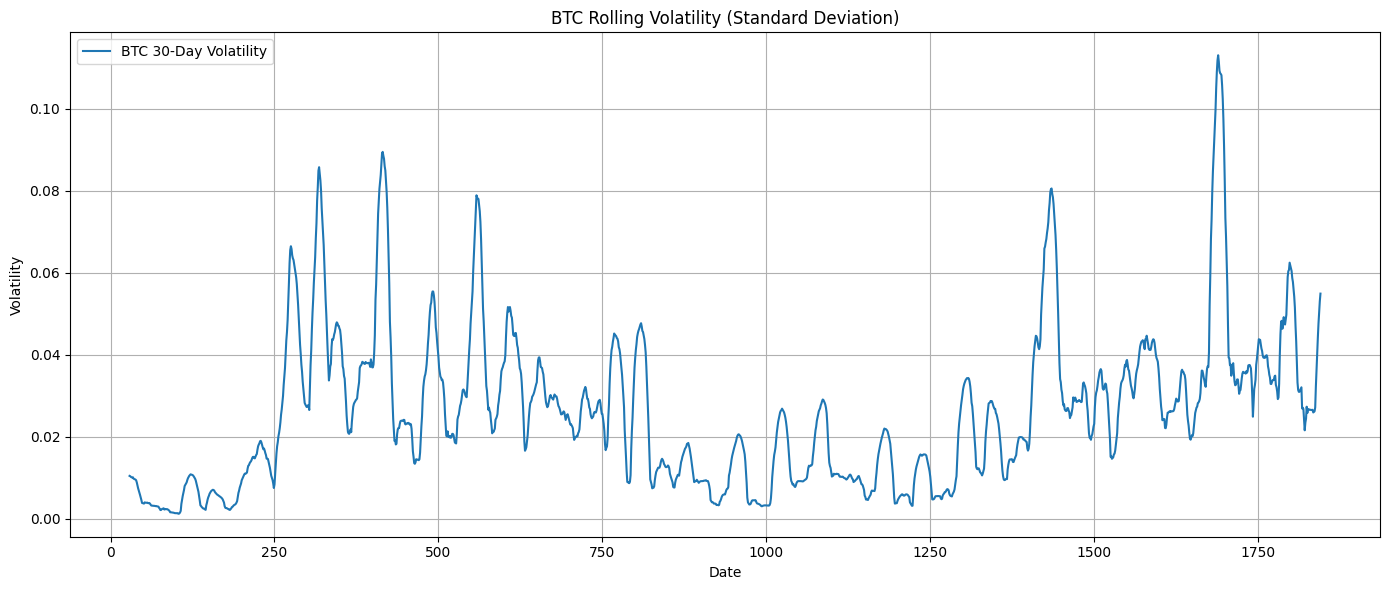

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(crypto_scaled_df['BTC'].rolling(window=30).std(), label='BTC 30-Day Volatility')
plt.title('BTC Rolling Volatility (Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model Training

#### Feature Engineering

In [15]:
# Make plots larger and more readable
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# First, let's check what our dataset looks like
print("Dataset shape:", crypto_ml_df.shape)
print("\nFirst 5 rows:")
display(crypto_ml_df.head())

# Check for missing values
print("\nMissing values:")
print(crypto_ml_df.isnull().sum())

# Convert Date column to datetime format if not already
if not pd.api.types.is_datetime64_any_dtype(crypto_ml_df['Date']):
    crypto_ml_df['Date'] = pd.to_datetime(crypto_ml_df['Date'])

# Set Date as index
crypto_ml_df.set_index('Date', inplace=True)

# Sort by date to ensure chronological order
crypto_ml_df.sort_index(inplace=True)

# Display basic statistics
print("\nBasic statistics:")
display(crypto_ml_df.describe())


Dataset shape: (1846, 13)

First 5 rows:


Price,Date,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
0,2020-04-10,6865.493164,43622840992,158.412445,17980944616,13.737724,394331907,0.033215,95977717,0.951054,87364276,0.187464,2105282079
1,2020-04-11,6859.083008,31222085946,158.216019,13555089447,13.804288,364313702,0.033354,75648111,0.776819,43862444,0.188063,1847482831
2,2020-04-12,6971.091797,35759567632,161.142426,15123721386,14.375111,414752932,0.033806,73751090,0.882507,38736897,0.190135,2087857417
3,2020-04-13,6845.037598,38619308647,156.279556,16465282133,15.034427,459561236,0.033107,84000834,0.777832,18211285,0.187732,2253497429
4,2020-04-14,6842.427734,34110434052,157.596390,14723156630,15.525076,515331620,0.032974,74633336,0.661925,16747614,0.185335,1889687587



Missing values:
Price       Ticker 
Date                   0
BTC         BTC-USD    0
BTC_volume  BTC-USD    0
ETH         ETH-USD    0
ETH_volume  ETH-USD    0
BNB         BNB-USD    0
BNB_volume  BNB-USD    0
ADA         ADA-USD    0
ADA_volume  ADA-USD    0
SOL         SOL-USD    0
SOL_volume  SOL-USD    0
XRP         XRP-USD    0
XRP_volume  XRP-USD    0
dtype: int64

Basic statistics:


Price,BTC,BTC_volume,ETH,ETH_volume,BNB,BNB_volume,ADA,ADA_volume,SOL,SOL_volume,XRP,XRP_volume
Ticker,BTC-USD,BTC-USD,ETH-USD,ETH-USD,BNB-USD,BNB-USD,ADA-USD,ADA-USD,SOL-USD,SOL-USD,XRP-USD,XRP-USD
count,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03,1846.000000,1.846000e+03
mean,41409.036062,3.356761e+10,2108.780745,1.709505e+10,343.314414,1.511664e+09,0.662946,1.400200e+09,74.935236,1.790551e+09,0.717463,3.368577e+09
std,23948.192080,2.024404e+10,1073.111682,1.091745e+10,197.773702,1.374472e+09,0.560069,2.030534e+09,70.881991,2.277911e+09,0.581058,4.538622e+09
min,6642.109863,5.331173e+09,153.286896,2.081626e+09,13.737724,1.365992e+08,0.031863,5.825736e+07,0.515273,6.520200e+05,0.175870,2.253910e+08
25%,22632.334961,2.043979e+10,1516.558167,9.640550e+09,237.622849,5.309764e+08,0.314543,3.022042e+08,19.182549,2.783352e+08,0.390422,1.094784e+09
50%,37324.607422,2.963824e+10,1937.230713,1.488192e+10,313.467438,1.302818e+09,0.451191,6.364651e+08,38.678888,1.146799e+09,0.529640,1.773782e+09
75%,58192.470703,4.075462e+10,2961.470825,2.116080e+10,529.586929,1.953729e+09,0.923297,1.535035e+09,138.468311,2.585399e+09,0.759323,3.457406e+09
max,106146.265625,3.509679e+11,4812.087402,9.245355e+10,750.272644,1.798295e+10,2.968239,1.914198e+10,261.869751,3.317296e+10,3.298635,5.172338e+10


In [16]:
# Create a new dataframe to work with, focusing on BTC
btc_df = crypto_ml_df[['BTC', 'BTC_volume']].copy()

# Feature 1: Add lag features (previous days' prices)
for i in range(1, 31):
    btc_df[f'BTC_lag_{i}'] = btc_df['BTC'].shift(i)

In [17]:
# Feature 2: Rolling statistics
btc_df['rolling_mean_7d'] = btc_df['BTC'].rolling(window=7).mean()
btc_df['rolling_mean_30d'] = btc_df['BTC'].rolling(window=30).mean()
btc_df['rolling_std_7d'] = btc_df['BTC'].rolling(window=7).std()
btc_df['rolling_std_30d'] = btc_df['BTC'].rolling(window=30).std()


In [18]:
# Feature 3: Technical indicators
# Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc_df['RSI_14'] = calculate_rsi(btc_df['BTC'], 14)

In [19]:
# Moving Average Convergence Divergence (MACD)
btc_df['EMA_12'] = btc_df['BTC'].ewm(span=12, adjust=False).mean()
btc_df['EMA_26'] = btc_df['BTC'].ewm(span=26, adjust=False).mean()
btc_df['MACD'] = btc_df['EMA_12'] - btc_df['EMA_26']
btc_df['MACD_signal'] = btc_df['MACD'].ewm(span=9, adjust=False).mean()

In [20]:
# Feature 4: Calendar features
btc_df['day_of_week'] = btc_df.index.dayofweek
btc_df['month'] = btc_df.index.month

In [44]:
# Feature 5: Add other crypto prices as features
crypto_list = ['ETH', 'BNB', 'ADA', 'SOL', 'XRP']

# Just add all the cryptos directly without checking correlation
for crypto in crypto_list:
    try:
        if crypto in crypto_ml_df.columns:
            btc_df[crypto] = crypto_ml_df[crypto]
            print(f"Added {crypto} as a feature")
    except Exception as e:
        print(f"Error adding {crypto}: {e}")

Added ETH as a feature
Added BNB as a feature
Added ADA as a feature
Added SOL as a feature
Added XRP as a feature


In [45]:
# Display the features we've created
print("\nFeatures after engineering:")
print(btc_df.columns.tolist())


Features after engineering:
[('BTC', 'BTC-USD'), ('BTC_volume', 'BTC-USD'), ('BTC_lag_1', ''), ('BTC_lag_2', ''), ('BTC_lag_3', ''), ('BTC_lag_4', ''), ('BTC_lag_5', ''), ('BTC_lag_6', ''), ('BTC_lag_7', ''), ('BTC_lag_8', ''), ('BTC_lag_9', ''), ('BTC_lag_10', ''), ('BTC_lag_11', ''), ('BTC_lag_12', ''), ('BTC_lag_13', ''), ('BTC_lag_14', ''), ('BTC_lag_15', ''), ('BTC_lag_16', ''), ('BTC_lag_17', ''), ('BTC_lag_18', ''), ('BTC_lag_19', ''), ('BTC_lag_20', ''), ('BTC_lag_21', ''), ('BTC_lag_22', ''), ('BTC_lag_23', ''), ('BTC_lag_24', ''), ('BTC_lag_25', ''), ('BTC_lag_26', ''), ('BTC_lag_27', ''), ('BTC_lag_28', ''), ('BTC_lag_29', ''), ('BTC_lag_30', ''), ('rolling_mean_7d', ''), ('rolling_mean_30d', ''), ('rolling_std_7d', ''), ('rolling_std_30d', ''), ('RSI_14', ''), ('EMA_12', ''), ('EMA_26', ''), ('MACD', ''), ('MACD_signal', ''), ('day_of_week', ''), ('month', ''), ('ETH', ''), ('BNB', ''), ('ADA', ''), ('SOL', ''), ('XRP', '')]


In [46]:
# Drop rows with NaN values (these will be at the beginning due to lag features)
btc_df.dropna(inplace=True)

In [47]:
# Display the processed dataframe
print("\nProcessed data shape:", btc_df.shape)
display(btc_df.head())


Processed data shape: (1816, 48)


Price,BTC,BTC_volume,BTC_lag_1,BTC_lag_2,BTC_lag_3,BTC_lag_4,BTC_lag_5,BTC_lag_6,BTC_lag_7,BTC_lag_8,...,EMA_26,MACD,MACD_signal,day_of_week,month,ETH,BNB,ADA,SOL,XRP
Ticker,BTC-USD,BTC-USD,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-10,8756.430664,63325279337,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,8897.468750,8988.596680,...,8402.581976,598.179882,556.974947,6,5,188.599564,15.295669,0.047677,0.537034,0.198176
2020-05-11,8601.795898,57119858802,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,8897.468750,...,8417.338563,522.043917,549.988741,0,5,185.912842,15.097545,0.048108,0.515273,0.194064
2020-05-12,8804.477539,42142717533,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,8912.654297,...,8446.015524,472.612349,534.513463,1,5,189.312500,15.741054,0.050421,0.538576,0.197637
2020-05-13,9269.987305,45558144023,8804.477539,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,9003.070312,...,8507.050471,465.632700,520.737310,2,5,199.193283,16.138878,0.051472,0.550532,0.201480
2020-05-14,9733.721680,56426907637,9269.987305,8804.477539,8601.795898,8756.430664,9593.896484,9842.666016,9951.518555,9268.761719,...,8597.915005,491.851013,514.960051,3,5,202.949097,16.357800,0.050890,0.569118,0.203129


#### Target Variables and Train-Test Split

In [48]:
# Define target variable - using BTC price directly
X = btc_df.drop('BTC', axis=1)  # All features
y = btc_df['BTC']               # Target

/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_21486/852993497.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = btc_df.drop('BTC', axis=1)  # All features


In [49]:
# Define the date for train-test split (December 31, 2024)
split_date = '2024-12-31'

# Verify if this date exists in our dataset
if split_date in btc_df.index:
    print(f"Split date {split_date} exists in dataset")
else:
    # If no suitable date, split by percentage
    split_idx = int(len(btc_df) * 0.8)
    split_date = btc_df.index[split_idx]
    print(f"Using {split_date} as split date (80% of data)")

# Split data into train and test sets
X_train = X[X.index <= split_date]
X_test = X[X.index > split_date]
y_train = y[y.index <= split_date]
y_test = y[y.index > split_date]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Split date 2024-12-31 exists in dataset

Training data shape: (1697, 47)
Testing data shape: (119, 47)


#### Time Series Modeling - ARIMA and Prophet

In [50]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    directional_accuracy = np.mean((np.diff(y_true) > 0) == (np.diff(y_pred) > 0)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Directional Accuracy (%)': directional_accuracy,
        'R2': r2
    }

Fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29310.880, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29306.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29305.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29305.975, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29306.622, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29307.139, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29307.174, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29309.070, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29306.317, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.638 seconds

ARIMA Metrics:
MAE: 8433.9743
RMSE: 10118.6745
MAPE: 9.6539
Directional Accuracy (%): 49.1525
R2: -0.7634


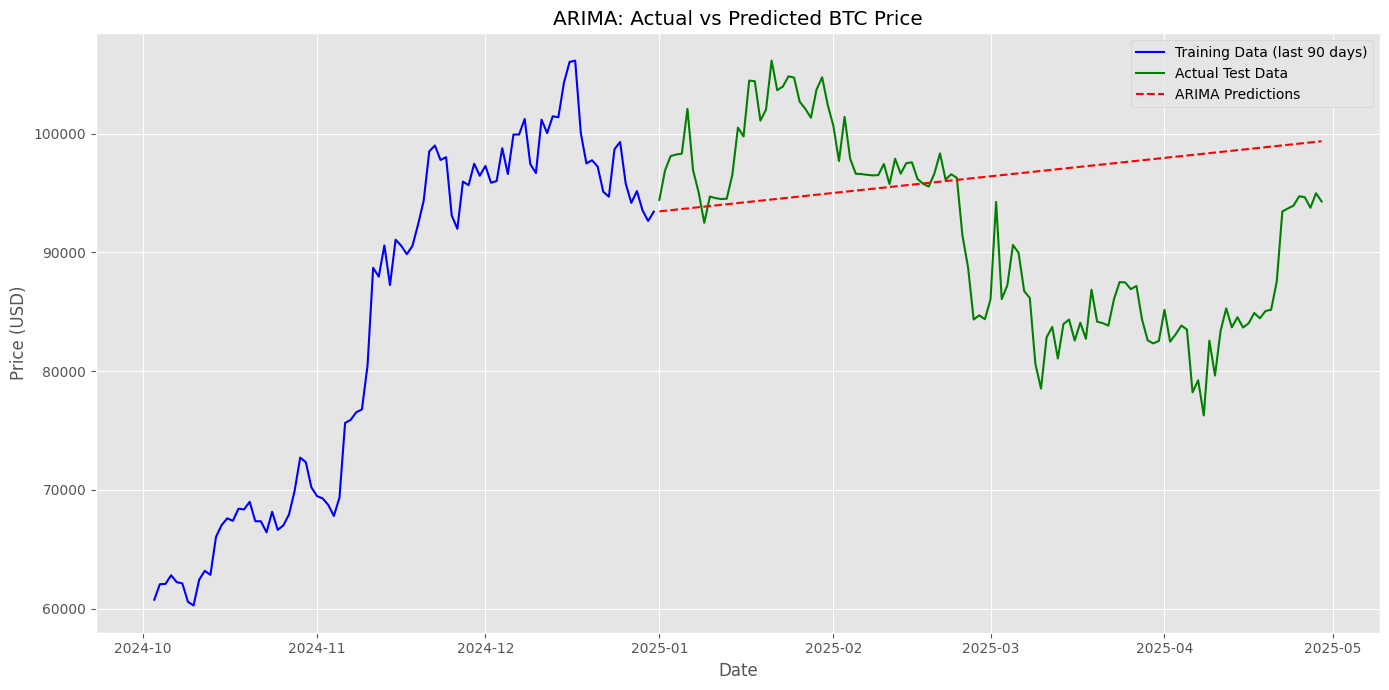

In [51]:
import pmdarima as pm
import warnings
import traceback
import numpy as np

# Suppress sklearn deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 1. ARIMA Model
print("Fitting ARIMA model...")
try:
    # Extract and flatten the arrays to ensure they're 1D
    y_train_values = y_train.values.flatten() if y_train.values.ndim > 1 else y_train.values
    y_test_values = y_test.values.flatten() if y_test.values.ndim > 1 else y_test.values
    
    # Convert to pandas Series with proper index
    y_train_series = pd.Series(y_train_values, index=y_train.index)
    y_test_series = pd.Series(y_test_values, index=y_test.index)
    
    # Use auto_arima to find the best parameters
    arima_model = pm.auto_arima(
        y_train_series,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        max_order=None,
        trace=True
    )
    
    # Make predictions - create new Series with matching index
    n_periods = len(y_test_series)
    arima_preds_values = arima_model.predict(n_periods=n_periods)
    arima_preds = pd.Series(arima_preds_values, index=y_test_series.index[:len(arima_preds_values)])
    
    # Make sure we only use matching dates for evaluation
    y_test_subset = y_test_series.loc[arima_preds.index]
    
    # Calculate metrics
    arima_metrics = calculate_metrics(y_test_subset, arima_preds)
    print("\nARIMA Metrics:")
    for key, value in arima_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train_series.index[-90:], y_train_series[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(y_test_subset.index, y_test_subset, 'g-', label='Actual Test Data')
    plt.plot(arima_preds.index, arima_preds, 'r--', label='ARIMA Predictions')
    plt.title('ARIMA: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in ARIMA modeling: {e}")
    traceback.print_exc()

16:47:25 - cmdstanpy - INFO - Chain [1] start processing



Fitting Prophet model...


16:47:26 - cmdstanpy - INFO - Chain [1] done processing



Prophet Metrics:
MAE: 17905.5506
RMSE: 21326.6208
MAPE: 20.6039
Directional Accuracy (%): 50.0000
R2: -6.8334


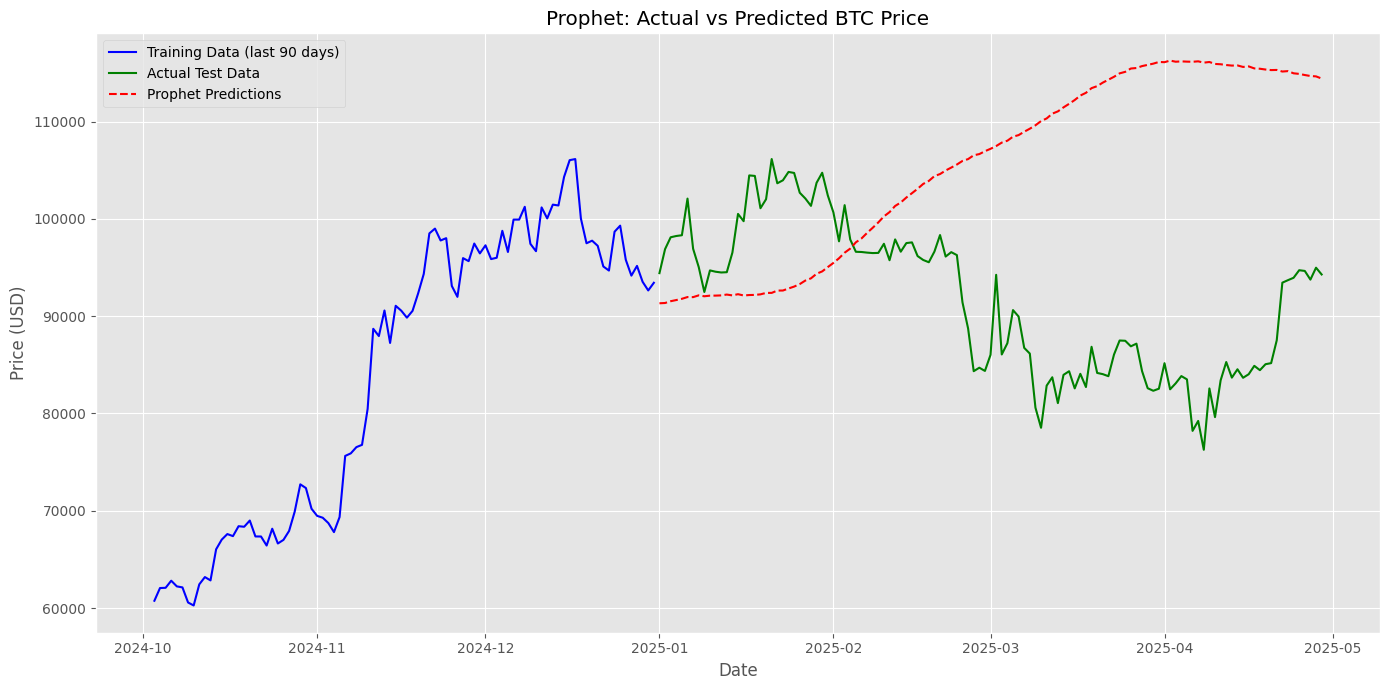

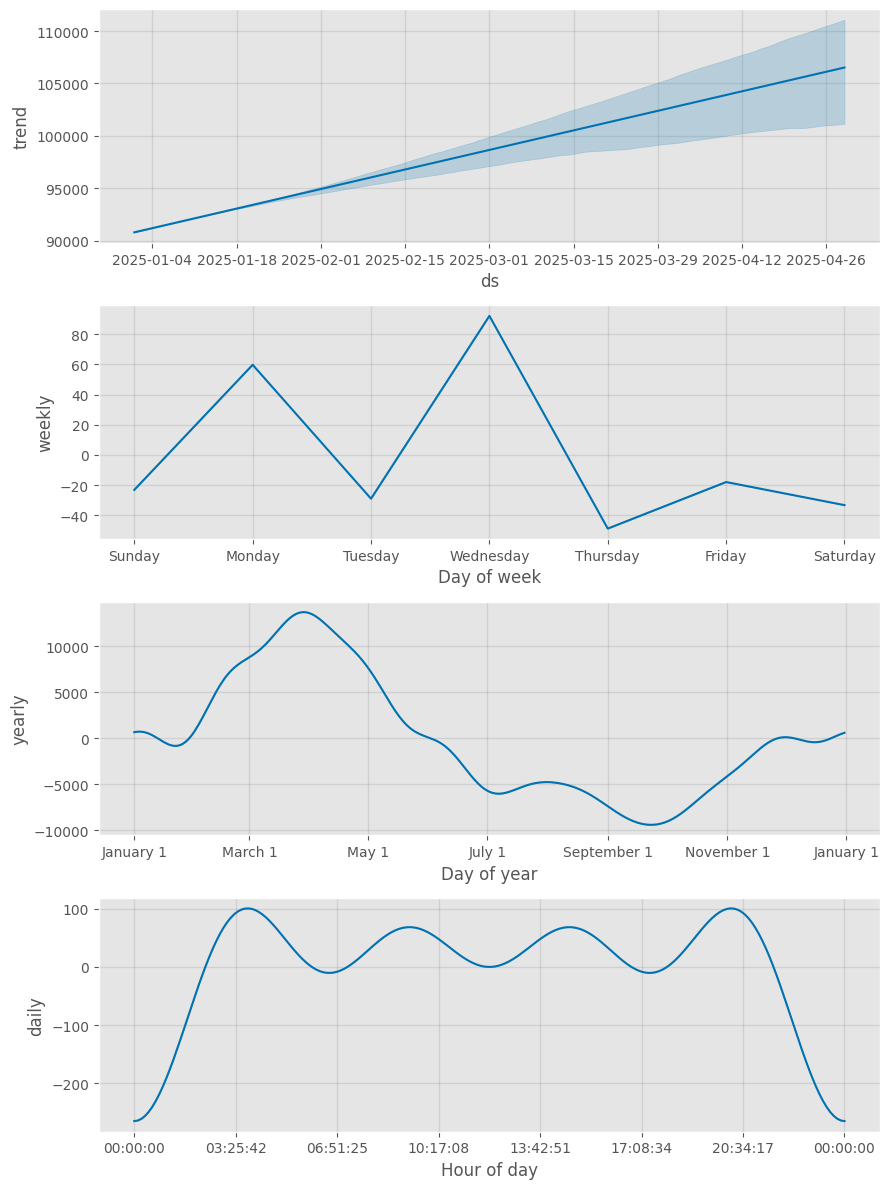

In [52]:
# 2. Prophet Model
print("\nFitting Prophet model...")
try:
    # Convert index to datetime if needed
    y_train_index = pd.to_datetime(y_train.index)
    y_test_index = pd.to_datetime(y_test.index)
    
    # Flatten arrays to ensure they're 1D
    y_train_values = y_train.values.flatten() if y_train.values.ndim > 1 else y_train.values
    y_test_values = y_test.values.flatten() if y_test.values.ndim > 1 else y_test.values
    
    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': y_train_index,  # Dates go in 'ds' column
        'y': y_train_values   # Values go in 'y' column
    })
    
    # Initialize and fit Prophet model
    prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet_model.fit(prophet_train)
    
    # Create future dataframe for prediction that matches exactly with test data
    future_dates = pd.DataFrame({
        'ds': y_test_index  # Using test dates
    })
    
    # Generate forecast
    prophet_forecast = prophet_model.predict(future_dates)
    
    # Extract predictions with proper index alignment
    prophet_preds = pd.Series(
        prophet_forecast['yhat'].values, 
        index=pd.to_datetime(prophet_forecast['ds']).dt.date
    )
    
    # Convert test data index to date for proper comparison
    y_test_date_index = pd.Series(y_test_values, index=pd.to_datetime(y_test.index).date)
    
    # Find common dates
    common_dates = sorted(set(prophet_preds.index).intersection(set(y_test_date_index.index)))
    
    # Filter both series to include only common dates
    aligned_preds = prophet_preds.loc[common_dates]
    aligned_test = y_test_date_index.loc[common_dates]
    
    # Calculate metrics
    prophet_metrics = calculate_metrics(aligned_test, aligned_preds)
    print("\nProphet Metrics:")
    for key, value in prophet_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(pd.to_datetime(y_train.index)[-90:], y_train_values[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(aligned_test.index, aligned_test, 'g-', label='Actual Test Data')
    plt.plot(aligned_preds.index, aligned_preds, 'r--', label='Prophet Predictions')
    
    plt.title('Prophet: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Also show Prophet's components
    fig = prophet_model.plot_components(prophet_forecast)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"An error occurred in Prophet model: {e}")
    traceback.print_exc()

#### Machine Learning Models

Training Random Forest model...
Debug - X_train shape: (1697, 47), y_train shape: (1697,)
Debug - Predictions shape: (119,)
Debug - y_test shape: (119,)

Random Forest Metrics:
MAE: 5529.8155
RMSE: 6916.6566
MAPE: 6.3788
Directional Accuracy (%): 56.7797
R2: 0.1761


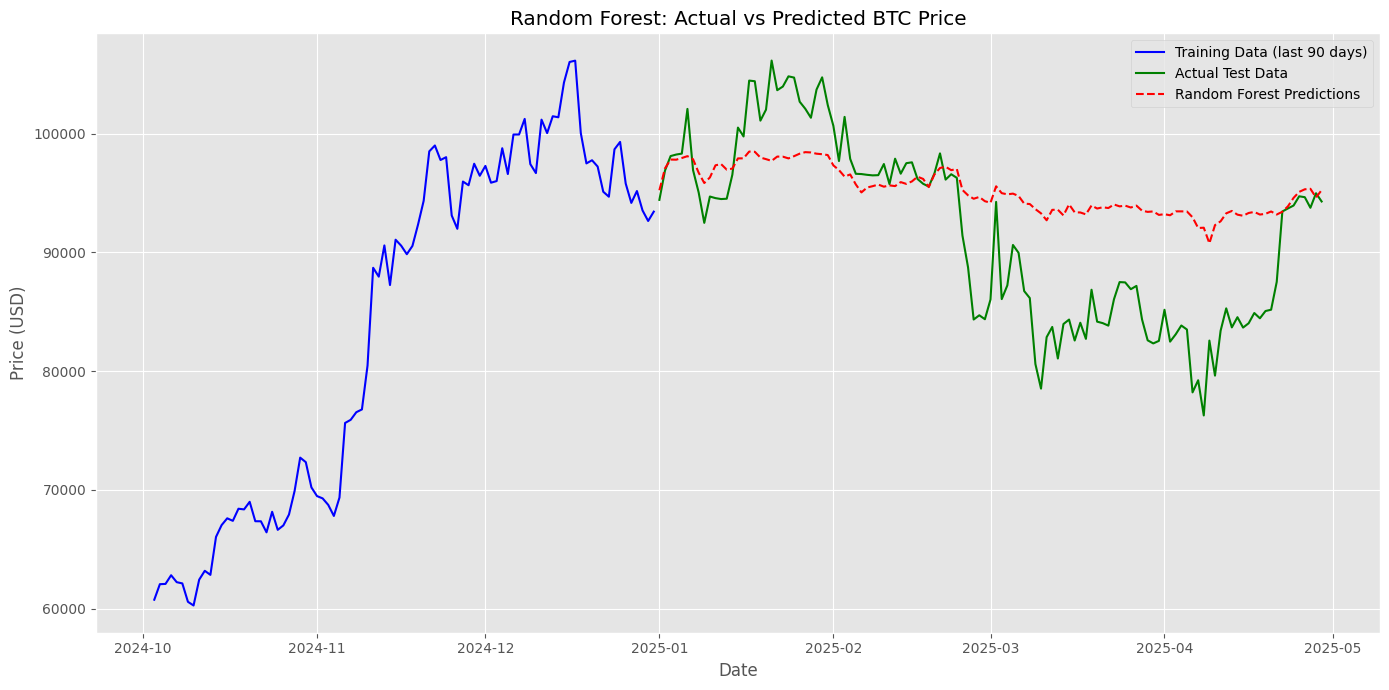

In [53]:
# Random Forest model with careful array handling
print("Training Random Forest model...")
try:
    # Explicitly convert to numpy arrays
    X_train_np = X_train.values
    X_test_np = X_test.values
    
    # Get 1D array for target 
    if hasattr(y_train, 'values'):
        y_train_np = y_train.values.flatten() if y_train.values.ndim > 1 else y_train.values
    else:
        y_train_np = np.array(y_train).flatten()
    
    print(f"Debug - X_train shape: {X_train_np.shape}, y_train shape: {y_train_np.shape}")
    
    # Scale the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_test_scaled = scaler.transform(X_test_np)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model with explicitly flattened target
    rf_model.fit(X_train_scaled, y_train_np)
    
    # Make predictions
    rf_preds = rf_model.predict(X_test_scaled)
    print(f"Debug - Predictions shape: {rf_preds.shape}")
    
    # For safety, ensure y_test is properly formatted
    if hasattr(y_test, 'values'):
        y_test_np = y_test.values.flatten() if y_test.values.ndim > 1 else y_test.values
    else:
        y_test_np = np.array(y_test).flatten()
    
    print(f"Debug - y_test shape: {y_test_np.shape}")
    
    # Ensure predictions and test data have same length
    min_len = min(len(rf_preds), len(y_test_np))
    rf_preds_trimmed = rf_preds[:min_len]
    y_test_trimmed = y_test_np[:min_len]
    
    # Create Series with proper index for plotting
    if hasattr(y_test, 'index'):
        indices = y_test.index[:min_len]
    else:
        indices = np.arange(min_len)
    
    rf_preds_series = pd.Series(rf_preds_trimmed, index=indices)
    y_test_series = pd.Series(y_test_trimmed, index=indices)
    
    # Calculate metrics with our robust function
    rf_metrics = calculate_metrics(y_test_series, rf_preds_series)
    print("\nRandom Forest Metrics:")
    for key, value in rf_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot results if we have valid predictions
    if min_len > 0:
        plt.figure(figsize=(14, 7))
        if hasattr(y_train, 'index'):
            plt.plot(y_train.index[-min(90, len(y_train)):], 
                    y_train.values[-min(90, len(y_train)):].flatten(), 
                    'b-', label='Training Data (last 90 days)')
        plt.plot(y_test_series.index, y_test_series, 'g-', label='Actual Test Data')
        plt.plot(rf_preds_series.index, rf_preds_series, 'r--', label='Random Forest Predictions')
        plt.title('Random Forest: Actual vs Predicted BTC Price')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Error in Random Forest modeling: {e}")
    import traceback
    traceback.print_exc()

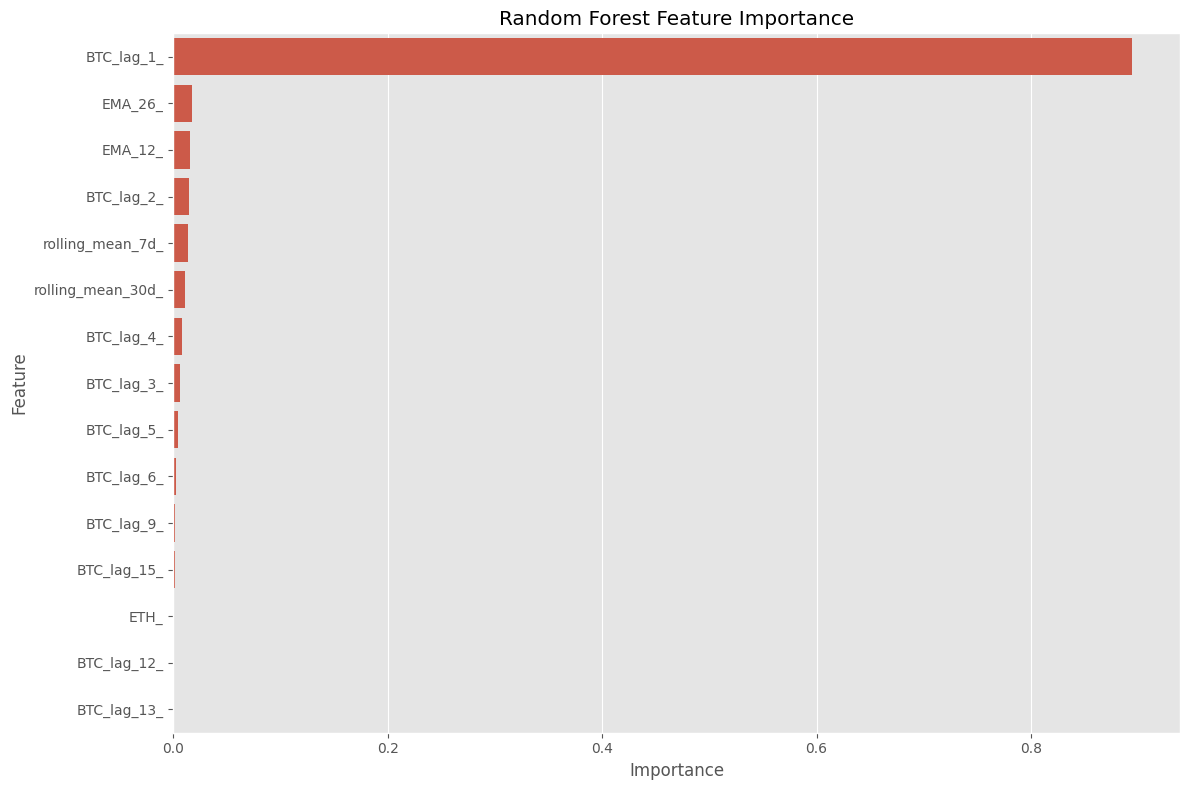

In [54]:
# Extract feature importance
importances = rf_model.feature_importances_

# Convert feature names to flat strings to avoid MultiIndex issue
if hasattr(X_train, 'columns'):
    if isinstance(X_train.columns, pd.MultiIndex):
        # For MultiIndex, convert each tuple to a string with '_' separator
        feature_names = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) and len(col) > 1 
                         else str(col) for col in X_train.columns]
    else:
        # For regular Index, convert to list of strings
        feature_names = [str(col) for col in X_train.columns]
else:
    # Fallback if X_train has no columns attribute
    feature_names = [f"Feature {i}" for i in range(len(importances))]

# Create DataFrame with simple string feature names
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Now plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


Training XGBoost model...

XGBoost Metrics:
MAE: 4931.7614
RMSE: 5824.2424
MAPE: 5.6529
Directional Accuracy (%): 65.2542
R2: 0.4158


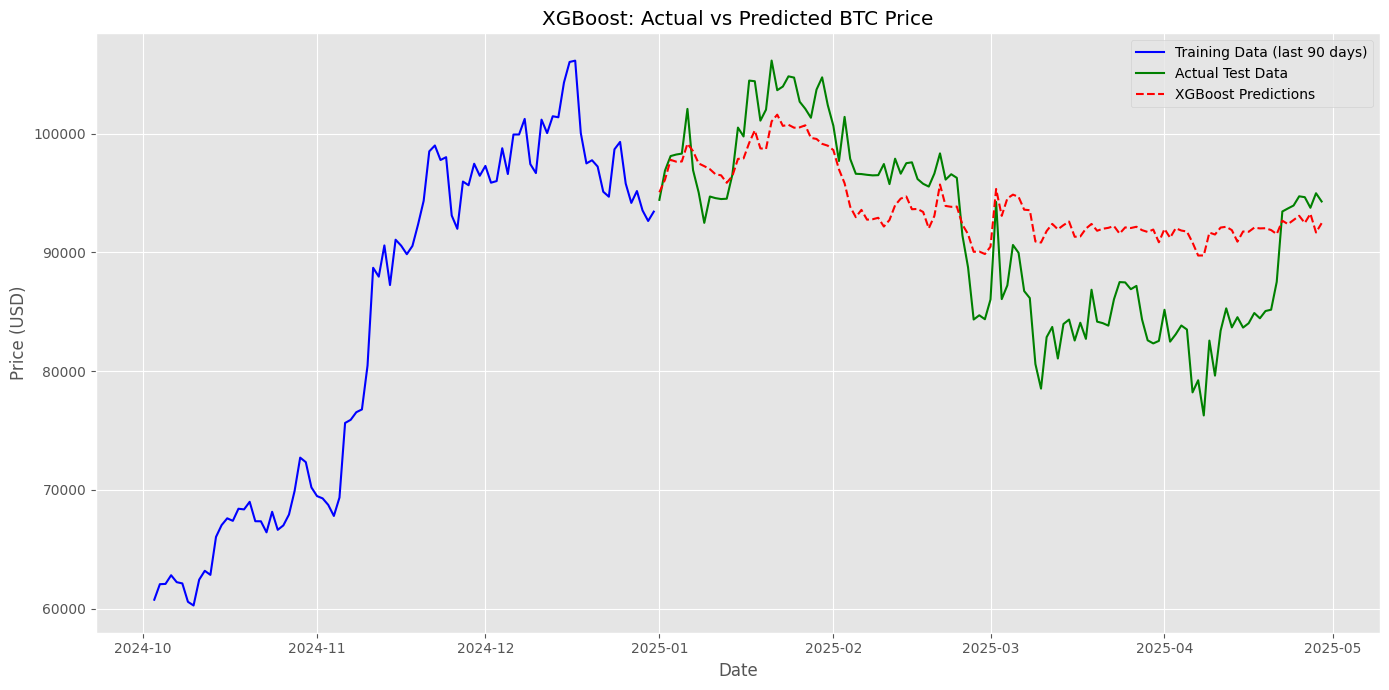

In [60]:
def calculate_metrics(y_true, y_pred):
    # Convert inputs to numpy arrays and flatten
    if hasattr(y_true, 'values'):
        y_true_values = y_true.values.flatten() if y_true.values.ndim > 1 else y_true.values
    else:
        y_true_values = np.array(y_true).flatten()
    
    if hasattr(y_pred, 'values'):
        y_pred_values = y_pred.values.flatten() if y_pred.values.ndim > 1 else y_pred.values
    else:
        y_pred_values = np.array(y_pred).flatten()
    
    # Ensure same length
    min_len = min(len(y_true_values), len(y_pred_values))
    y_true_values = y_true_values[:min_len]
    y_pred_values = y_pred_values[:min_len]
    
    # Calculate basic metrics
    mae = mean_absolute_error(y_true_values, y_pred_values)
    rmse = np.sqrt(mean_squared_error(y_true_values, y_pred_values))
    mape = mean_absolute_percentage_error(y_true_values, y_pred_values) * 100
    
    # Calculate directional accuracy safely
    if min_len >= 2:
        diff_true = np.diff(y_true_values)
        diff_pred = np.diff(y_pred_values)
        directional_accuracy = np.mean((diff_true > 0) == (diff_pred > 0)) * 100
    else:
        directional_accuracy = np.nan
    
    # Calculate R2
    r2 = r2_score(y_true_values, y_pred_values)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Directional Accuracy (%)': directional_accuracy,
        'R2': r2
    }

# Now train XGBoost with proper metrics calculation
print("\nTraining XGBoost model...")
try:
    # Train XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)

    # Make predictions
    xgb_preds = xgb_model.predict(X_test_scaled)
    
    # Create Series with proper index for predictions
    xgb_preds_series = pd.Series(xgb_preds, index=y_test.index[:len(xgb_preds)])
    
    # Calculate metrics using the robust function
    xgb_metrics = calculate_metrics(y_test, xgb_preds_series)
    print("\nXGBoost Metrics:")
    for key, value in xgb_metrics.items():
        print(f"{key}: {value:.4f}")

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
    plt.plot(y_test.index[:len(xgb_preds)], y_test[:len(xgb_preds)], 'g-', label='Actual Test Data')
    plt.plot(xgb_preds_series.index, xgb_preds_series, 'r--', label='XGBoost Predictions')
    plt.title('XGBoost: Actual vs Predicted BTC Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in XGBoost modeling: {e}")
    import traceback
    traceback.print_exc()

#### LSTM

In [72]:
# Use existing model for feature importances if available, else train one

if 'rf_model' in locals() or 'rf_model' in globals():
    print("Using Random Forest feature importance for selection")
    importances = rf_model.feature_importances_
elif 'xgb_model' in locals() or 'xgb_model' in globals():
    print("Using XGBoost feature importance for selection")
    importances = xgb_model.feature_importances_
else:
    print("Training a Random Forest model for feature selection")
    selector_model = RandomForestRegressor(n_estimators=100, random_state=42)
    selector_model.fit(X_train, y_train)
    importances = selector_model.feature_importances_

Using Random Forest feature importance for selection


In [73]:
# Create a DataFrame of features and their importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Choose top N features
top_n_features = 10
top_features = feature_importance.head(top_n_features)['Feature'].tolist()

print(f"Selected top {top_n_features} features:")
for i, feature in enumerate(top_features):
    importance = feature_importance.loc[feature_importance['Feature'] == feature, 'Importance'].values[0]
    print(f"{i+1}. {feature}: {importance:.4f}")


Selected top 10 features:
1. ('BTC_lag_1', ''): 0.8943
2. ('EMA_26', ''): 0.0177
3. ('EMA_12', ''): 0.0156
4. ('BTC_lag_2', ''): 0.0149
5. ('rolling_mean_7d', ''): 0.0138
6. ('rolling_mean_30d', ''): 0.0105
7. ('BTC_lag_4', ''): 0.0078
8. ('BTC_lag_3', ''): 0.0061
9. ('BTC_lag_5', ''): 0.0047
10. ('BTC_lag_6', ''): 0.0029


In [74]:
# Reduce feature sets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]
print(f"Reduced feature set shape: {X_train_reduced.shape}")

# Scale the data
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reduced)
X_test_scaled = X_scaler.transform(X_test_reduced)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


Reduced feature set shape: (1697, 10)


In [75]:
# Reshape for LSTM: [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

input_shape = (1, X_train_scaled.shape[1])
print(f"LSTM input shape: {input_shape}")


LSTM input shape: (1, 10)


In [82]:

model = Sequential([
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, return_sequences=True, dropout=0.2),
    LSTM(16, dropout=0.2),
    Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model with reduced feature set...")
history = model.fit(
    X_train_lstm, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Training LSTM model with reduced feature set...
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0703 - val_loss: 0.2459
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - val_loss: 0.0103
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 12/100
43

In [83]:
# Predict
lstm_predictions_scaled = model.predict(X_test_lstm)
lstm_predictions = y_scaler.inverse_transform(lstm_predictions_scaled)

# Evaluate
lstm_metrics = calculate_metrics(y_test, lstm_predictions)
print("\nLSTM Model Metrics with Reduced Features:")
for key, value in lstm_metrics.items():
    print(f"{key}: {value:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

LSTM Model Metrics with Reduced Features:
MAE: 2535.8967
RMSE: 3373.4963
MAPE: 2.8201
Directional Accuracy (%): 49.1525
R2: 0.8040


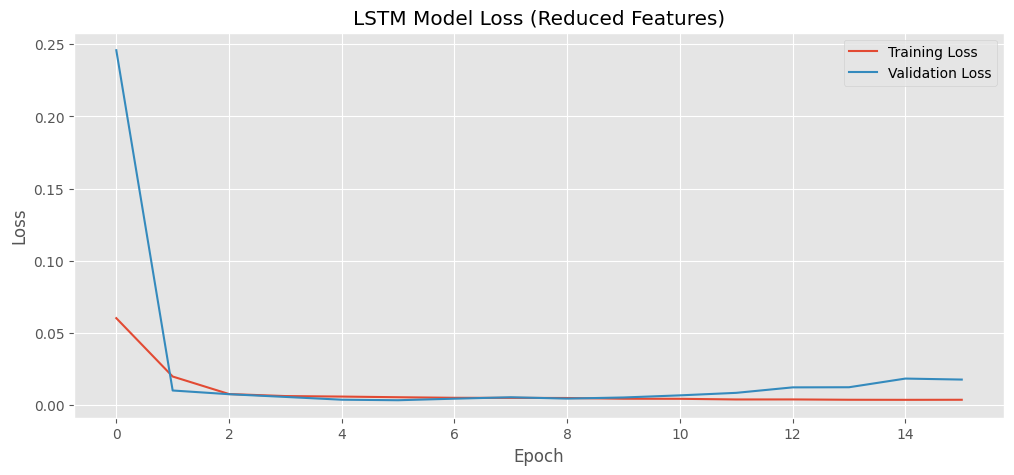

In [84]:
import matplotlib.pyplot as plt

# Loss Plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss (Reduced Features)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


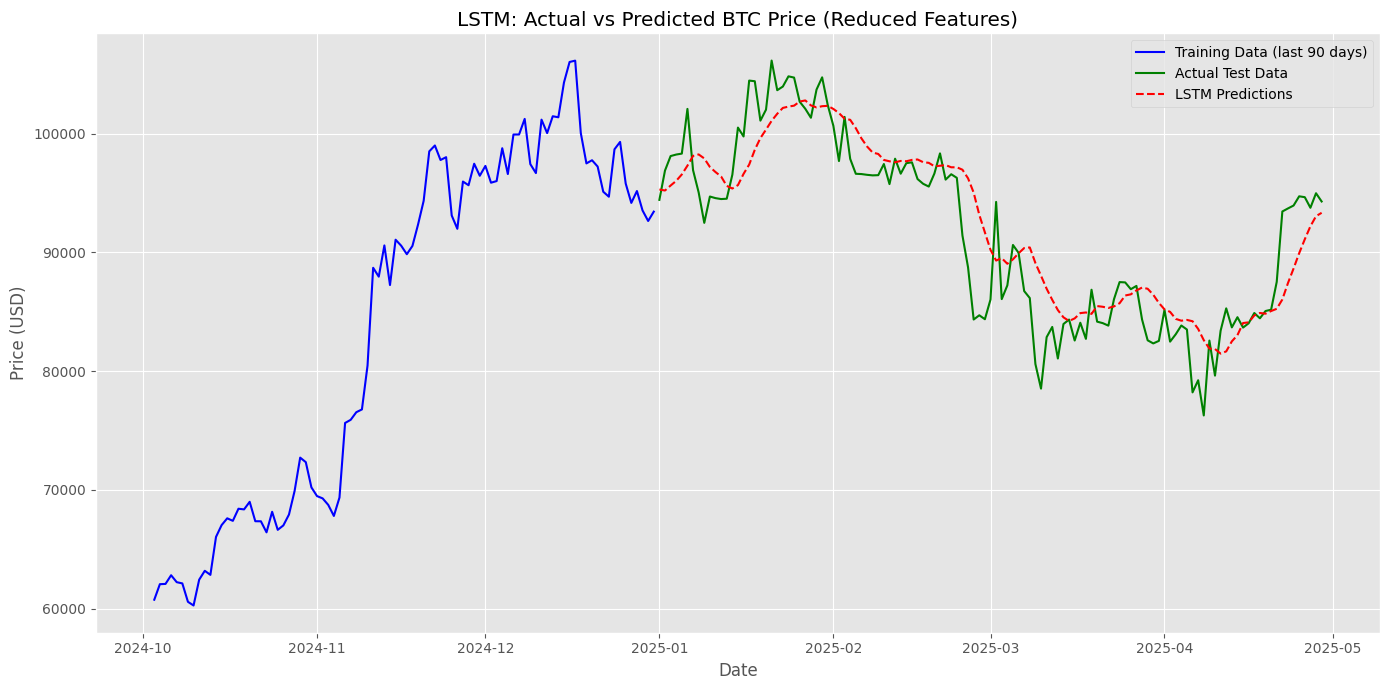

In [85]:
# Prediction Plot
plt.figure(figsize=(14, 7))
plt.plot(y_train.index[-90:], y_train[-90:], 'b-', label='Training Data (last 90 days)')
plt.plot(y_test.index, y_test, 'g-', label='Actual Test Data')
plt.plot(y_test.index, lstm_predictions, 'r--', label='LSTM Predictions')
plt.title('LSTM: Actual vs Predicted BTC Price (Reduced Features)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Multi-Step Forecasting (7-day ahead)

In [87]:
def forecast_multi_step(model, X_last, steps=7, is_lstm=False, feature_scaler=None, target_scaler=None):
    forecasts = []
    
    # Make a copy of the last observation to avoid modifying the original
    current_X = X_last.copy()
    
    for _ in range(steps):
        # Make prediction
        if is_lstm:
            # For LSTM models
            current_X_reshaped = current_X.reshape(1, 1, current_X.shape[1])
            forecast_scaled = model.predict(current_X_reshaped)
            forecast = target_scaler.inverse_transform(forecast_scaled)[0][0] if target_scaler else forecast_scaled[0][0]
        else:
            # For traditional models like XGBoost - don't change the shape
            forecast_scaled = model.predict(current_X)
            forecast = target_scaler.inverse_transform([[forecast_scaled[0]]])[0][0] if target_scaler else forecast_scaled[0]
        
        forecasts.append(forecast)
        
        # Update features for next prediction
        # This is a simplified approach - in reality, you'd need to update each feature appropriately
        # For demonstration, we'll just update the price feature (assuming it's the first feature)
        if feature_scaler and target_scaler:
            # If we have scalers, we need to:
            # 1. Update the scaled price feature with the scaled prediction
            # 2. For other features, you'd need domain knowledge to update them
            
            # For now, we'll just shift all features (might not be realistic)
            current_X = np.roll(current_X, -1, axis=1)
            current_X[0, -1] = forecast_scaled[0]
            
        else:
            # Without scalers, we'll just use a simple approach
            # In a real implementation, you'd update features based on domain knowledge
            pass
            
    return forecasts

# Prepare for multi-step forecasting with XGBoost
print("Generating multi-step forecast with XGBoost...")
try:
    # Get the last observation from the training set
    X_last = X_train_scaled[-1:].copy()  # Keep as 2D array with shape (1, n_features)
    
    # Make sure X_last has the correct shape
    print(f"Last observation shape: {X_last.shape}")
    print(f"Expected features by model: {xgb_model.n_features_in_}")
    
    # Generate 7-day forecast
    multi_step_forecast = forecast_multi_step(
        model=xgb_model, 
        X_last=X_last, 
        steps=7,
        is_lstm=False,
        feature_scaler=X_scaler,
        target_scaler=y_scaler if 'y_scaler' in locals() else None
    )
    
    # Get the first 7 days of the test set for comparison
    first_week_actual = y_test[:7].values
    
    # Calculate metrics for the 7-day forecast
    forecast_metrics = {
        'MAE': mean_absolute_error(first_week_actual, multi_step_forecast),
        'RMSE': np.sqrt(mean_squared_error(first_week_actual, multi_step_forecast)),
        'MAPE': mean_absolute_percentage_error(first_week_actual, multi_step_forecast) * 100
    }
    
    print("\nXGBoost 7-Day Forecast Metrics:")
    for key, value in forecast_metrics.items():
        print(f"{key}: {value:.4f}")
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index[-30:], y_train[-30:], 'b-', label='Historical Data (last 30 days)')
    
    # Create date range for forecast
    if hasattr(y_test.index, 'date'):
        forecast_dates = y_test.index[:7].date
    else:
        forecast_dates = y_test.index[:7]
        
    plt.plot(forecast_dates, first_week_actual, 'g-', label='Actual Future Prices')
    plt.plot(forecast_dates, multi_step_forecast, 'r--', label='XGBoost 7-Day Forecast')
    
    plt.title('XGBoost: 7-Day Bitcoin Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in multi-step forecasting: {e}")
    import traceback
    traceback.print_exc()

Generating multi-step forecast with XGBoost...
Last observation shape: (1, 10)
Expected features by model: 47
Error in multi-step forecasting: Feature shape mismatch, expected: 47, got 10


Traceback (most recent call last):
  File "/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_21486/3530768675.py", line 67, in <module>
    multi_step_forecast = forecast_multi_step(
                          ^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/_5/m_34c02s1l37sw92qsz9t6t00000gn/T/ipykernel_21486/3530768675.py", line 32, in forecast_multi_step
    forecast_scaled = model.predict(current_X)
                      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py", line 1327, in predict
    predts = self.get_booster().inplace_predict(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return 